# Text Mining: Proyecto semestral

Juan Pablo Muñoz

martes, 26 de febrero del 2019




## Introducción

En este *notebook* se resumen los experimentos y avances logrados en el desarrollo del proyecto semestral del curso *Text Mining* 2018-2. El proyecto tiene por objetivo aplicar los conocimientos adquiridos durante el curso para proponer una solución a algún problema dentro o fuera del área, con algún elemento novedoso.

Este proyecto propone una serie de métodos y algoritmos para la creación de vectores de palabras basados en Word2vec que no sufran del problema de la *fusión de significados*

La *fusión de significados* es una propiedad indeseada que se manifiesta en las representaciones vectoriales que se basan en Word2vec. En su formato original, Word2vec intenta generar un espacio vectorial en el que cada palabra observada pueda ser representada, de manera que, en el nuevo espacio, ésta quede cerca de las palabras que tienden a aparecer en su cercanía, a la vez que queda lejos de palabras que tienden a no aparecer cerca o en una misma frase. Pero este modelo de representación no considera dos propiedades muy importantes de la semántica: 1) que las palabras pueden tener varios significados y 2) que el significado de una palabra en uso depende fuertemente de las palabras que la rodean (contexto). Esta limitación del diseño de Word2vec causa que el modelo, por ejemplo, sólo produzca una única representación para la palabra "ratón", cuando en realidad "ratón" puede referirse a un animal mamífero o a un dispositivo tecnológico. Al mismo tiempo, el modelo se esforzará por hacer que todas las palabras fuertemente relacionadas a "ratón (animal)" y "ratón (tecnología)" queden cerca de la representación fusionada de "ratón", por lo que se deshace la propiedad distributiva del espacio vectorial resultante.


## Metodología de Trabajo

El proceso de creación de vectores Word2vec tiene las siguientes etapas:

 - Obtención de un corpus, que es un conjunto de documentos de texto
 - Preprocesar el corpus
 - Crear y entrenar un modelo Word2vec sobre el corpus preprocesado
 
Para poner en uso el modelo de representación creado, debe existir una consulta. Esta consulta es una cadena de texto, que debe ser preprocesada de la misma manera que el corpus antes de crear el modelo, para luego ser transformada al espacio de representación del modelo, donde se puede realizar la tarea que se requiera (por ejemplo, recuperación de información o resolución de preguntas, entre otros).
 
** La etapa más importante, costosa y complicada en este proyecto resulta ser el de preprocesamiento de texto**. Fue experimentando aquí donde se concentró todo el esfuerzo y tiempo del proyecto.

Luego de lograda esa parte, se puede entrenar un modelo word2vec para realizar *tests* de coherencia interna del espacio vectorial y para realizar *downstream tasks*. Sin embargo, estas actividades sólo sirven para el propósito de validación y no se les dio prioridad en esta iteración del trabajo.

## Datos

El corpus utilizado fue el depósito general de artículos de la Wikipedia en inglés: [enwiki-latest-pages-articles-multistream.xml.bz](https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles-multistream.xml.bz2) (tamaño ~15 GB con ~4.5 millones de artículos). Para los experimentos realizados, se utilizó una muestra aleatoria de un ~10% de los artículos.

Los métodos y algoritmos desarrollados utilizan fuentes de conocimiento léxico externas al corpus de texto utilizado para entrenar. En esta iteración del trabajo, se utiliza WordNet y la interfaz de NLTK para tener acceso simplificado a las estructuras de datos léxicas y a las operaciones realizables sobre ellas.

## Descripción del Preprocesado

Nota: Debido al alto costo computacional que tiene (de momento) decidir a priori si una palabra es o no ambigua, y la desambiguación implementada, se requiere de la indicación explícita de aquellas palabras a desambiguar durante el preprocesado del corpus.

A continuación, se describe el preprocesado del corpus, dada una lista de palabras ambiguas. Los nombres y argumentos descritos aquí no corresponden a los implementados. Esta modificación se hizo para priorizar rapidez de escritura y facilidad de entendimiento. La descripción detallada de las funciones se encuentra en cada implementación.

```
def preprocesado(corpus, lista_palabras_ambiguas):
  corpus_preprocesado = list()
  for documento in corpus:
    tokenizar(documento)
    remover_stopwords(documento)
    lematizar(documento)
    hacer_part_of_speech_tag(documento)
    desambiguar(documento, lista_palabras_ambiguas)
    corpus_preprocesado.append(documento)
  return corpus_preprocesado
```

Del anterior proceso, es necesario explicar `desambiguar()`:

```
def desambiguar(documento, lista_palabras_ambiguas):
  for palabra in documento:
    if palabra in lista_palabras_ambiguas:
      contexto = ventana(documento, palabra)
      palabra_desambiguada = decidir_significado(palabra, contexto)
      reemplazar(documento, palabra, palabra_desambiguada)
    return documento
```

Donde, `decidir_significado()` es una función que accede a los diccionarios de WordNet y permite decidir el significado más probable de una palabra dado su contexto, en base a múltiples métricas de similitud definidas sobre las estructuras de datos de WordNet llamadas `Synsets`, que se comportan como grafos y son utilizadas para representar relaciones jerárquicas entre términos relacionados, definiciones, ejemplos, etc.

Es importante destacar que sólo se van a desambiguar sustantivos y verbos; los adjetivos y adverbios sólo aportan información adicional y no suelen sufrir del problema de la ambigüedad.

## Código

### Clase y métodos para cargar el corpus de Wikipedia haciendo primeros pasos de preprocesado

Cargar el archivo `bz2` del corpus de la Wikipedia con una clase especialmente diseñada en la librería **gensim**. Esta clase permite realizar tokenización, transformación a letras minúsculas, remoción de *stop words*, lematización y *part-of-speech tagging* al momento de la carga de cada artículo. De manera adicional, se implementa y aplica sobre cada artículo una función normalizadora `remove_accents()`, que transforma los carácteres alfabéticos tildados a su forma original (ej.: "árbol"->"arbol").

In [0]:
from __future__ import print_function

import time
import logging
import os.path
import sys
import random

import unicodedata

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode('utf-8')


import nltk
from nltk.corpus import wordnet

lmtzr = nltk.WordNetLemmatizer().lemmatize

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


def lemmatize_text(text):
    word_pos = nltk.pos_tag(nltk.word_tokenize(text))
    lemm_words = [lmtzr(sw[0], get_wordnet_pos(sw[1])) for sw in word_pos]

    return [x.lower() for x in lemm_words]

'''
class gensim.corpora.wikicorpus.WikiCorpus(
    fname,
    processes=None, 
    lemmatize=True, 
    dictionary=None, 
    filter_namespaces=('0', ), 
    tokenizer_func=<function tokenize>, 
    article_min_tokens=50, 
    token_min_len=2, 
    token_max_len=15, 
    lower=True, 
    filter_articles=None
)

'''

from gensim.corpora import WikiCorpus

class WikiCorpusLoader:

    def __init__(self, wiki_dump_file, just_lemmatize=False, pos=False, dictionary={}):
        self.wiki = WikiCorpus(wiki_dump_file, lemmatize=pos, dictionary=dictionary)
        program = os.path.basename(sys.argv[0])
        self.logger = logging.getLogger(program)
        self.lemmatize = just_lemmatize
        self.pos = pos
        logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s')
        logging.root.setLevel(level=logging.INFO)
        self.logger.info("running %s" % ' '.join(sys.argv))
        
        
    def generate_sample(self, output_file, sample_frac=0.01, random_state_seed=99):
        assert sample_frac > 0 and sample_frac <= 1
        #assert not os.path.exists(output_file)
        output_no_lemma = open(output_file+'_no_lemma.txt', 'w')
        if self.lemmatize:
            output_lemma = open(output_file+'_lemma.txt', 'w')
        if self.pos:
            output_pos = open(output_file+'_pos.txt', 'w')
        i = 0
        idx = 0
        period = 100000
        if self.pos:
            period = 2000
        random.seed(random_state_seed)
        for article in self.wiki.get_texts():
            idx += 1
            if sample_frac < 1:
                article_selected = random.random() <= sample_frac
                if not article_selected:
                    continue
            else:
                i = i + 1
                if not self.pos:
                    normalized_article = bytes(' '.join(remove_accents(w) for w in article), 'utf-8').decode('utf-8')
                else:
                    normalized_article = ' '.join(remove_accents(w.decode('utf-8')) for w in article)
                output_no_lemma.write(str(idx)+':'+normalized_article+'\n')
                if self.lemmatize:
                    output_lemma.write(str(idx)+':'+' '.join(lemmatize_text(normalized_article))+'\n')
                if self.pos:
                    output_pos.write(str(idx)+'\n')
                
                if (i % period == 0):
                    self.logger.info("Saved " + str(i) + " articles")
        output_no_lemma.close()
        if self.lemmatize:
            output_lemma.close()
        if self.pos:
            output_pos.close()
        self.logger.info("Finished saving " + str(i) + " articles.")

### Funciones para la desambiguación de un corpus preprocesado

Estas funciones permiten iterar sobre los documentos preprocesados, realizando desambiguación automática de todas las palabras que se hayan indicado. Luego de este paso, el corpus queda listo para ser usado en el entrenamiento de modelos Word2vec.

In [1]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords

def get_similarity(ss1, ss2, method='path'):
  if method =='path':
    return max(
        s for s in [
            0,
            wn.path_similarity(ss1,ss2,simulate_root=True),
            wn.path_similarity(ss2,ss1,simulate_root=True),
        ] if s is not None
    )
  if method =='wup':
    return max(
        s for s in [
            0,
            wn.wup_similarity(ss1,ss2,simulate_root=True),
            wn.wup_similarity(ss2,ss1,simulate_root=True),
        ] if s is not None
    )


def perform_disambiguation(
    document,
    target_word_index,
    method='path',
    verbose=False,
):
  
  '''
  disambiguates a word given a context, by comparing all WordNet synsets of the
  target word with those of the words in the context
  word: 2-tuple (<token>, <pos_tag>)
  context: list of 2-tuples [(<token>, <pos_tag>), ...]
  
  Method: Choose the meaning that maximizes the sum of similarities between it
  and the most similar sense of every word in the context.
  
  Intuitively: Select the meaning that "makes the more sense" possible given the
  most convenient interpretation of every word in the context.
  
  Note: currently using path-based similarity -> Higher similarity when score is
  higher.
  
  TODO: if the document has desambiguated words, use them as they come
  '''
  
  assert target_word_index < len(document) and 0 <= target_word_index
  
  word_and_pos = document[target_word_index]
  word = word_and_pos[0]
  pos_tag = word_and_pos[1]
  context_pre = document[0:target_word_index]
  context_post = document[target_word_index+1:]
  context = context_pre+context_post
  
  candidate_meanings = wn.synsets(word, pos=pos_tag)
  if not candidate_meanings:
      # Ignore PoS tag if no candidates
      candidate_meanings = wn.synsets(word)
  
  '''
  Base case: if the target word is not in WordNet, OR its POS-tag corresponds to
  an adjective or adverb, return the document unmodified
  '''
  
  if not candidate_meanings or pos_tag in [wn.ADJ, wn.ADV]:
    return list(w[0] for w in document)

  scores = dict()
  # Iterate over all possible meanings of the word to be disambiguated
  # Evaluate "how much sense" makes the candidate meaning with the context
  for candidate_meaning in candidate_meanings:
    similarities = []
    for context_word, context_pos in context:
        if context_pos in [wn.ADJ, wn.ADV]:
            continue
        sim_list = []
        context_word_synsets = wn.synsets(context_word, pos=context_pos)
        if not context_word_synsets:
            context_word_synsets = wn.synsets(context_word)
        if not context_word_synsets:
            #print('****HEY:',context_word)
            continue
        for context_word_synset in context_word_synsets:
            
            sim_list.append(
                (candidate_meaning.name(), context_word_synset.name(), \
                get_similarity(candidate_meaning, context_word_synset, method))
            )
        similarities.append(sim_list)
    
    '''
    # Evaluate "how much sense" makes the candidate meaning with the context
    similarities = [[(candidate_meaning.name(), context_word_synset.name(), \
        get_similarity(candidate_meaning, context_word_synset, method)) \
        for context_word_synset in wn.synsets(context_word, pos=context_pos)
    ] for context_word, context_pos in context if context_pos not in \
        [wn.ADJ, wn.ADV]]
    '''
    
    d = list()
    for target_context_similarities in similarities:
      d.append(max(list(zip(*target_context_similarities))[-1]))
    scores[candidate_meaning.name()] = sum(d)
  
    # Print partial results if required
    if verbose:
      print('Context:',context)
      for candidate_results in similarities:
        for (target, context_word, similarity) in candidate_results:
          print('similarity({:>20}, {:>20}) = {:>4}'.format(
              target,
              context_word,
              round(similarity, 2)
          ))
  
  # Choose the meaning that makes the "more sense"
  result = max(scores, key=scores.get)
  
  # Strip PoS tags off since they are no longer needed
  tagless_context_pre = []
  tagless_context_post = []
  if len(context_pre) > 0:
    tagless_context_pre = [w for w, tag in context_pre]
  if len(context_post) > 0:
    tagless_context_post = [w for w, tag in context_post]
    
  # Reconstruct document with the disambiguated target word
  result_doc = tagless_context_pre+[result]+tagless_context_post
  return result_doc

def penn_to_wn(pos_tag):
    if pos_tag.startswith('J'):
        return wn.ADJ
    elif pos_tag.startswith('N'):
        return wn.NOUN
    elif pos_tag.startswith('R'):
        return wn.ADV
    elif pos_tag.startswith('V'):
        return wn.VERB
    return None

def penn_to_wn_document(doc):
  wn_doc = []
  for token, pos_tag in doc:
    wn_doc.append((token, penn_to_wn(pos_tag)))
  return wn_doc
  
def pattern_to_wn_pos_transform(document):
  
  '''
  ['token_1/POS_1', ...] -> [('token_1', 'POS_1'), ...]
  '''
  
  r = [(t.split('/')[0], t.split('/')[1]) for t in document]
  return r
  
def disambiguate_article(
    document, 
    word_list, 
    pos_tagged=False, 
    method='path',
    window_size=2,
    verbose=False,
    print_disambiguations=True,
):
  
  '''
  Processes a document, first by stripping any stop words off it, then by
  performing a PoS tagging for specific words to be disambiguated and their 
  contexts, of size window_size. After the PoS tagging, tries to disambiguate 
  the target word.
  
  document: list of word strings
  word_list: words to be PoS tagged
  pos_tagged: True if document comes already PoS tagged (format: 'token/POS')
  method: 'path' for path-based similarity measure. 'ic' for 
  information-content-based similarity measure (TODO: support for 'ic')
  window_size: number of words before and after a target word to be considered
  as its context. Ideally, a bigger window should improve the quality of the PoS
  tagging and disambiguation until certain point (too big windows sizes could 
  span more than one context, phrase or paragraph).
  '''
  if pos_tagged:
    document = pattern_to_wn_pos_transform(document)
  else:
    stopwords_eng = stopwords.words('english')
    document = [token for token in document if token not in stopwords_eng]
    document = nltk.pos_tag(document)
    
  document = penn_to_wn_document(document)
  disambiguated_doc = ['']*len(document)
  modified_words_indexes = list()
  
  for index, w in enumerate(document):
    if disambiguated_doc[index] != '':
      continue
    tagless_w = w[0]
    disambiguated_doc[index] = tagless_w
    if tagless_w in word_list:
      window_start = max(0, index-window_size)
      window_end = min(len(document), index+window_size+1)
      target_w_index = index-window_start
      window = document[window_start:window_end]
      
      disambiguated_w = perform_disambiguation(
          window, 
          target_w_index,
          method=method,
          verbose=verbose,
      )
      was_modified = tagless_w != disambiguated_w[target_w_index]
      if was_modified and print_disambiguations:
        print('{:>15} -> {:>20}'.format(tagless_w, disambiguated_w[target_w_index]))
      modified_words_indexes.append(index)
    
      disambiguated_doc[window_start:window_end] = disambiguated_w
      
    
  return disambiguated_doc, modified_words_indexes

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Juampiblo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Juampiblo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Juampiblo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Lectura del corpus

In [0]:
# Lectura de corpus

%%time

print("Cargando y procesando corpus de Wikipedia...")
corpus_loader = WikiCorpusLoader(
    wiki_dump_file='data/enwiki-latest-pages-articles-multistream.xml.bz2',
    just_lemmatize=False,
    pos=True
)

corpus_loader.generate_sample(
    output_file='data/wikicorpus_0.1',
    sample_frac=0.1,
)

**Salida de la celda de lectura de corpus**:

2019-01-09 19:57:56,101: INFO: running c:\program files\python36\lib\site-packages\ipykernel_launcher.py -f C:\Users\Juampiblo\AppData\Roaming\jupyter\runtime\kernel-baa5de1c-3e6f-46dc-8875-cd40d4c3abe0.json

Cargando muestra del corpus de Wikipedia...

2019-01-09 20:02:45,123: INFO: Saved 1000 articles

2019-01-09 20:06:29,344: INFO: Saved 2000 articles

2019-01-09 20:09:38,782: INFO: Saved 3000 articles

...

2019-01-10 11:44:28,385: INFO: Saved 456000 articles

2019-01-10 11:45:24,977: INFO: Saved 457000 articles

2019-01-10 11:46:24,737: INFO: Saved 458000 articles

2019-01-10 11:47:15,700: INFO: finished iterating over Wikipedia corpus of 
4583951 documents with 2556203780 positions (total 19096287 articles, 
2624561277 positions before pruning articles shorter than 50 words)
2019-01-10 11:47:16,063: INFO: Finished saving 458949 articles.
Wall time: 15h 49min 19s

### Muestra del corpus cargado

Luego de la lectura del corpus, se produce un archivo de texto plano que contiene un artículo preprocesado por línea. Si se lee un artículo en una lista dividida por espacios (`split()`), el formato de cada artículo es el siguiente:

In [128]:
# Muestra de uno de los artículos del corpus y su formato final

a_sub = [
  'anarchism/NN',
  'be/VB',
  'political/JJ',
  'philosophy/NN',
  'advocate/VB',
  'self/NN',
  'govern/VB',
  'society/NN',
  'base/VB',
  'voluntary/JJ',
  'cooperative/JJ',
  'institution/NN',
  'reject/VB',
  'unjust/JJ',
  'hierarchy/NN',
  'institution/NN',
  'be/VB',
  'often/RB',
  'describe/VB',
  'stateless/JJ',
  'society/NN',
  'several/JJ',
  'author/NN',
  'have/VB',
  'define/VB',
  'more/RB',
  'specifically/RB',
  'institution/NN',
  'base/VB',
  'hierarchical/JJ',
  'free/JJ',
  'association/NN',
  'anarchism/NN',
  'hold/VB',
  'capitalism/NN',
  'state/NN'
]

### Desambiguación

A continuación, se realiza el último paso del preprocesado, que es la desambiguación.

Para desambiguar una palabra, se debe

 - Entregar un contexto (lista de palabras) que acompaña a la palabra a desambiguar. Recordar que el sentido de una palabra está fuertemente relacionado a las palabras de su contexto.
 - Entregar lematizados y PoS-taggeados tanto la palabra como el contexto. La lematización es un paso necesario para llevar todas las variaciones o conjugaciones de las palabras a su forma base, y permite identificarlas independientemente cómo se usen. El *PoS-tagging* permite a los métodos desamgibuadores reducir la cantidad inicial de significados posibles de una palabra ambigua. Si el *PoS-tagger* ha identificado a la palabra "light" como un adjetivo dado el contexto en el que se observó, entonces los métodos desambiguadores desambiguarán solamente considerando los significados de "light" que sean adjetivos entre los candidatos.
 
 La salida de la siguiente celda muestra el proceso comparativo que realizan los métodos desambiguadores sobre todos los significados candidatos de cada palabra ambigua (presente en la lista de palabras ambiguas `word_list`) encontrada.
 
Cuando se encuentra una palabra a desambiguar en el artículo, se cuantifica "cuánto sentido" tiene cada posible significado de la misma con las palabras de su contexto. Para esto, se comparan los `synsets` del significado candidato con todos los `synsets` de todas las palabras del contexto. Con `n` significados candidatos, dado un contexto de `m` palabras con `o` `synsets` cada una, la cantidad de veces que se aplica la medida de similitud entre `synsets` está en el orden `O(n*m*o)`.

In [129]:
%%time

a_sub_disambiguated, modified_words = disambiguate_article(
    document=a_sub,
    word_list=['society', 'govern', 'have', 'define', 'free'], 
    pos_tagged=True,
    method='wup',
    window_size=3,
    verbose=True,
    print_disambiguations=True
)

Context: [('philosophy', 'n'), ('advocate', 'v'), ('self', 'n'), ('society', 'n'), ('base', 'v'), ('voluntary', 'a')]
similarity(       regulate.v.02,        doctrine.n.01) = 0.18
similarity(       regulate.v.02,      philosophy.n.02) = 0.15
similarity(       regulate.v.02,      philosophy.n.03) = 0.18
similarity(       regulate.v.02,       recommend.v.01) = 0.22
similarity(       regulate.v.02,          preach.v.02) = 0.15
similarity(       regulate.v.02,            self.n.01) = 0.15
similarity(       regulate.v.02,            self.n.02) =  0.2
similarity(       regulate.v.02,         society.n.01) = 0.22
similarity(       regulate.v.02,            club.n.02) = 0.18
similarity(       regulate.v.02,         company.n.03) = 0.18
similarity(       regulate.v.02,         society.n.04) = 0.17
similarity(       regulate.v.02,       establish.v.08) =  0.4
similarity(       regulate.v.02,            base.v.02) = 0.29
similarity(       regulate.v.02,       free-base.v.01) = 0.29
Context: [('ph

### Comparación normal vs. desambiguado

Se puede comparar la muestra del artículo previo y posterior a la desambiguación:

In [130]:
print('{:>15} | {}'.format('ANTES', 'DESPUÉS'))
print('{:>15} | {}'.format('---------------', '---------------'))
for w, x in zip(a_sub, a_sub_disambiguated):
  print('{:>15} | {}'.format(w.split('/')[0], x))

          ANTES | DESPUÉS
--------------- | ---------------
      anarchism | anarchism
             be | be
      political | political
     philosophy | philosophy
       advocate | advocate
           self | self
         govern | regulate.v.02
        society | society
           base | base
      voluntary | voluntary
    cooperative | cooperative
    institution | institution
         reject | reject
         unjust | unjust
      hierarchy | hierarchy
    institution | institution
             be | be
          often | often
       describe | describe
      stateless | stateless
        society | society.n.01
        several | several
         author | author
           have | have
         define | specify.v.03
           more | more
   specifically | specifically
    institution | institution
           base | base
   hierarchical | hierarchical
           free | free
    association | association
      anarchism | anarchism
           hold | hold
     capitalism | capitalism


In [2]:
import time
import datetime

def load_ambiguous_word_list(list_path):
    l = list()
    with open(list_path, 'r') as f:
        for w in f.readlines():
            l.append(w.split('\n')[0])
    return l

def load_and_process_corpus(
    corpus_path, 
    ambiguous_list,
    corpus_no_disambiguation,
    corpus_disambiguation,
    similarity_method='path',
    disambiguation_window_size=2,
    is_pos_tagged=False, 
    verbose_process=True,
):
    disambiguated_words_indices_per_document = dict()
    log_progress_step = 1000
    buff = 0
    time_progress_step = 60*5
    start = time.time()
    time_buff = 0
    time_step = start
    with open(corpus_path, 'r') as f:
        for line in f.readlines():
            [doc_id, doc] = line.split(':')
            doc = doc.split('\n')[0].split()
            corpus_no_disambiguation[doc_id] = doc
            disambiguated_doc, disambiguated_words_indexes = disambiguate_article(
                document=doc, 
                word_list=ambiguous_list, 
                pos_tagged=is_pos_tagged,
                method=similarity_method,
                window_size=disambiguation_window_size, 
                verbose=False,
                print_disambiguations=False
            )
            corpus_disambiguation[doc_id] = disambiguated_doc
            disambiguated_words_indices_per_document[doc_id] = disambiguated_words_indexes
            # Logging part
            if verbose_process:
                buff += 1
                time_buff = int(time.time()-time_step)
            if verbose_process and (buff == log_progress_step or time_buff >= time_progress_step):
                buff = 0
                time_buff = 0
                time_step = time.time()
                total_time = str(datetime.timedelta(seconds=int(time.time()-start)))
                total_processed = len(corpus_disambiguation)
                total_disambiguated = sum([len(l) for l in disambiguated_words_indices_per_document.values()])
                data = (
                    total_time,
                    total_processed, 
                    total_disambiguated,
                    int(total_disambiguated/total_processed),
                )
                print('[Total time: {}] Disambiguated {} documents and a total of {} individual words (avg.: {} individual words/document)'.format(*data))
    return corpus_no_disambiguation, corpus_disambiguation

In [123]:
list_path = 'data/ordered_ambiguous_list.txt'
ambiguous_list = load_ambiguous_word_list(list_path)

In [124]:
%%time

corpus_path = 'data/wikicorpus_0.02_lemma.txt'
corpus_no_disambiguation = dict()
corpus_disambiguation = dict()
load_and_process_corpus(
    corpus_path,
    ambiguous_list,
    corpus_no_disambiguation,
    corpus_disambiguation,
    similarity_method='path',
    disambiguation_window_size=5,
    is_pos_tagged=False, 
    verbose_process=True,
)

[Total time: 0:05:16] Disambiguated 39 documents and a total of 9156 individual words (avg.: 234 individual words/document)
[Total time: 0:10:25] Disambiguated 89 documents and a total of 18205 individual words (avg.: 204 individual words/document)
[Total time: 0:15:26] Disambiguated 143 documents and a total of 28282 individual words (avg.: 197 individual words/document)
[Total time: 0:20:37] Disambiguated 188 documents and a total of 38451 individual words (avg.: 204 individual words/document)
[Total time: 0:25:41] Disambiguated 236 documents and a total of 47748 individual words (avg.: 202 individual words/document)
[Total time: 0:30:43] Disambiguated 286 documents and a total of 56464 individual words (avg.: 197 individual words/document)
[Total time: 0:36:06] Disambiguated 330 documents and a total of 66345 individual words (avg.: 201 individual words/document)
[Total time: 0:41:07] Disambiguated 422 documents and a total of 76241 individual words (avg.: 180 individual words/docum

[Total time: 5:34:09] Disambiguated 7319 documents and a total of 612512 individual words (avg.: 83 individual words/document)
[Total time: 5:39:09] Disambiguated 7507 documents and a total of 621843 individual words (avg.: 82 individual words/document)
[Total time: 5:44:11] Disambiguated 7659 documents and a total of 631059 individual words (avg.: 82 individual words/document)
[Total time: 5:49:13] Disambiguated 7811 documents and a total of 640287 individual words (avg.: 81 individual words/document)
[Total time: 5:54:13] Disambiguated 7984 documents and a total of 649699 individual words (avg.: 81 individual words/document)
[Total time: 5:59:14] Disambiguated 8128 documents and a total of 658541 individual words (avg.: 81 individual words/document)
[Total time: 6:04:14] Disambiguated 8286 documents and a total of 667718 individual words (avg.: 80 individual words/document)
[Total time: 6:09:15] Disambiguated 8433 documents and a total of 675762 individual words (avg.: 80 individual 

KeyboardInterrupt: 

In [125]:
import pickle

# Saving the objects:
with open('corpus_10kdocs_lemma_windowsize_5_method_path.pkl', 'wb') as f:
    pickle.dump([corpus_no_disambiguation, corpus_disambiguation], f)

In [4]:
import pickle

# Getting back the objects:
with open('corpus_10kdocs_lemma_windowsize_5_method_path.pkl', 'rb') as f:
    corpus_no_disambiguation, corpus_disambiguation = pickle.load(f)

In [5]:
from gensim.models import Word2Vec

model_no_disambiguation = Word2Vec(
    corpus_no_disambiguation.values(),
    size=128,
    window=5,
    min_count=20,
    workers=4,
    sg=1,
    compute_loss=True
)
model_no_disambiguation.train(corpus_no_disambiguation.values(), total_examples=len(corpus_no_disambiguation), epochs=10)

c:\program files\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


(88296147, 121504790)

In [6]:
model_no_disambiguation.wv.most_similar(positive='break')

c:\program files\python36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('blow', 0.5919524431228638),
 ('pull', 0.5863540768623352),
 ('shut', 0.5585645437240601),
 ('shove', 0.5570152997970581),
 ('knock', 0.5383119583129883),
 ('tear', 0.5368590950965881),
 ('sweep', 0.5353326797485352),
 ('turn', 0.5349311828613281),
 ('split', 0.5340461730957031),
 ('push', 0.5295044779777527)]

In [7]:
model_no_disambiguation.wv.most_similar(positive='title')

c:\program files\python36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('debut', 0.5670886635780334),
 ('filmography', 0.5070783495903015),
 ('flyweight', 0.49333977699279785),
 ('wbc', 0.4928619861602783),
 ('soundtrack', 0.49130672216415405),
 ('sequel', 0.48929283022880554),
 ('final', 0.48541831970214844),
 ('serie', 0.4853443503379822),
 ('jcw', 0.48268142342567444),
 ('shogakukan', 0.47251635789871216)]

In [8]:
from gensim.models import Word2Vec

model_disambiguation = Word2Vec(
    corpus_disambiguation.values(),
    size=128,
    window=5,
    min_count=20,
    workers=4,
    sg=1,
    compute_loss=True
)
model_disambiguation.train(corpus_disambiguation.values(), total_examples=len(corpus_disambiguation), epochs=10)

(69841430, 77069880)

In [9]:
model_disambiguation.wv.most_similar(positive='break')

c:\program files\python36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('interruption.n.02', 0.6151890158653259),
 ('pause.n.01', 0.6015561819076538),
 ('pull', 0.5351243615150452),
 ('end', 0.5301507115364075),
 ('shove', 0.5274057388305664),
 ('dislodge', 0.5178897380828857),
 ('start', 0.5142395496368408),
 ('fell', 0.5092427730560303),
 ('blow', 0.5086278915405273),
 ('catch.n.09', 0.49729520082473755)]

In [62]:
model_disambiguation.wv.most_similar(positive='title')

c:\program files\python36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('championship.n.01', 0.7452788352966309),
 ('title.n.08', 0.723073422908783),
 ('title.n.02', 0.5591039061546326),
 ('entitle.v.02', 0.5567129850387573),
 ('title.n.06', 0.5539853572845459),
 ('debut', 0.5163723230361938),
 ('wta', 0.5123984813690186),
 ('deed.n.01', 0.5080173015594482),
 ('title.n.07', 0.4985463619232178),
 ('iwgp', 0.4873659610748291)]

In [66]:
print(wn.synset('championship.n.01').definition())

the status of being a champion


In [47]:
model_disambiguation.wv.most_similar(positive='deployment')

c:\program files\python36\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('deploy', 0.7552586793899536),
 ('operation', 0.6456369757652283),
 ('expeditionary', 0.6209878921508789),
 ('patrol', 0.6205835342407227),
 ('adf', 0.6044753789901733),
 ('bct', 0.5942467451095581),
 ('readiness', 0.585975706577301),
 ('airlift', 0.5859397649765015),
 ('combat', 0.5850430130958557),
 ('operational', 0.5844811201095581)]

In [11]:
s1 = len(model_no_disambiguation.wv.vocab)
s2 = len(model_disambiguation.wv.vocab)
print('---10Kdocument Corpus---')
print('Vocab size of non-disambiguated corpus:', s1)
print('Vocab size of disambiguated corpus:', s2)
print('Vocab size difference after disambiguation: {} ({}%)'.format(s2-s1, round(100*s2/s1-100, 2)))

---10Kdocument Corpus---
Vocab size of non-disambiguated corpus: 25324
Vocab size of disambiguated corpus: 27456
Vocab size difference after disambiguation: 2132 (8.42%)


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


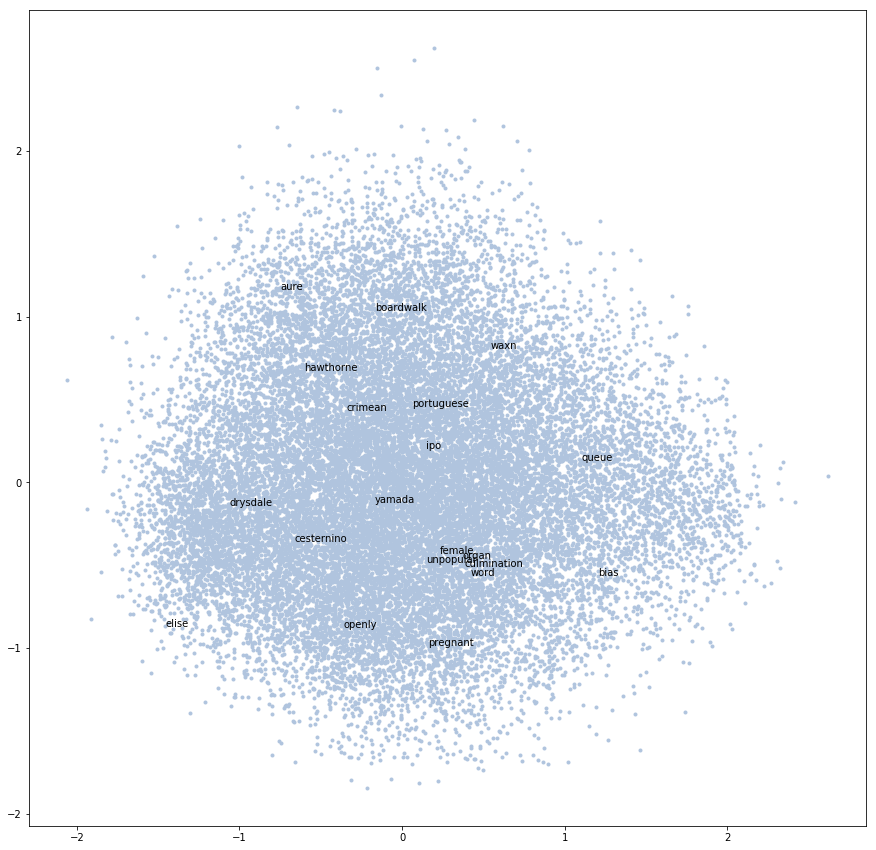

In [15]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import random

prob = 0.001

# fit a 2d PCA model to the vectors
X = model_no_disambiguation[model_no_disambiguation.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(15, 15))
plt.scatter(result[:, 0], result[:, 1], marker='.', c='lightsteelblue')
words = list(model_no_disambiguation.wv.vocab)
for i, word in enumerate(words):
    if random.random() <= prob:
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


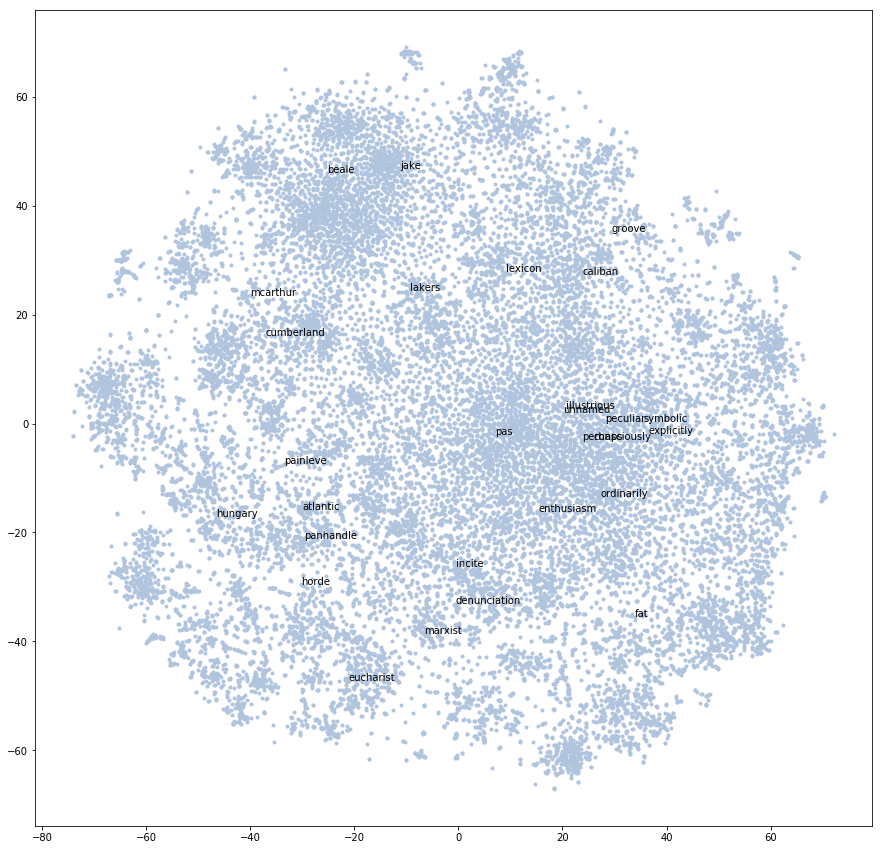

In [17]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import random

prob = 0.001

# fit a 2d TSNE model to the vectors
X = model_no_disambiguation[model_no_disambiguation.wv.vocab]
pca = PCA(n_components=50)
partial_result = pca.fit_transform(X)
tsne = TSNE(n_components=2)
result = tsne.fit_transform(partial_result)
# create a scatter plot of the projection
plt.figure(figsize=(15, 15))
plt.scatter(result[:, 0], result[:, 1], marker='.', c='lightsteelblue')
words = list(model_no_disambiguation.wv.vocab)
for i, word in enumerate(words):
    if random.random() <= prob:
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


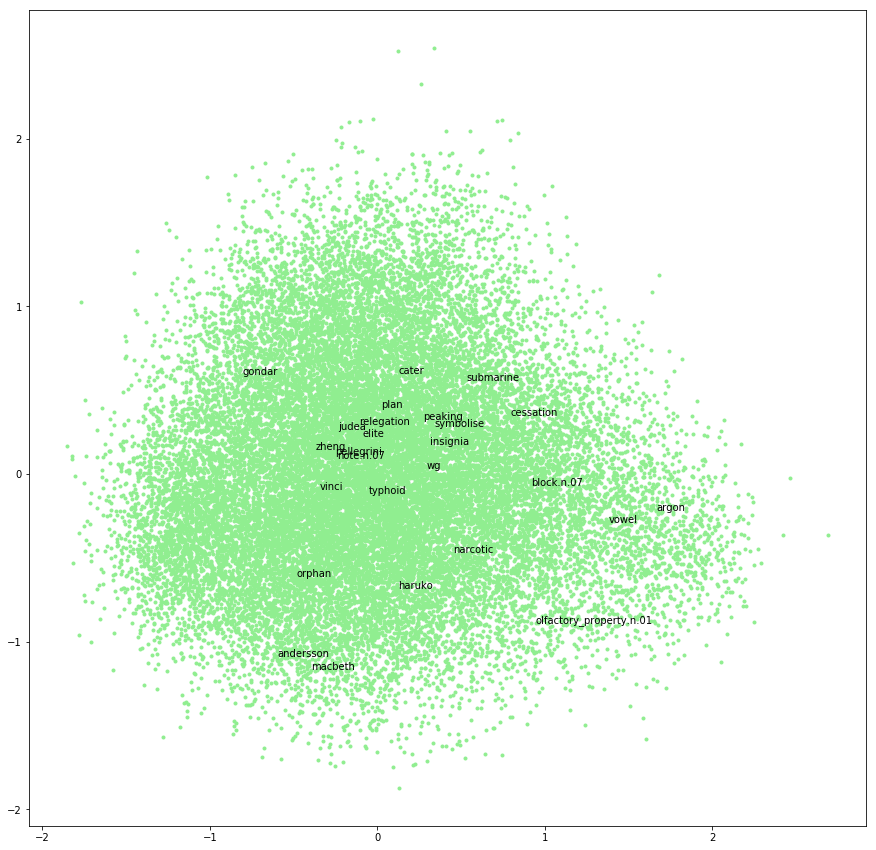

In [18]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import random

prob = 0.001

# fit a 2d PCA model to the vectors
X = model_disambiguation[model_disambiguation.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
plt.figure(figsize=(15, 15))
plt.scatter(result[:, 0], result[:, 1], marker='.', c='lightgreen')
words = list(model_disambiguation.wv.vocab)
for i, word in enumerate(words):
    if random.random() <= prob:
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

c:\program files\python36\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


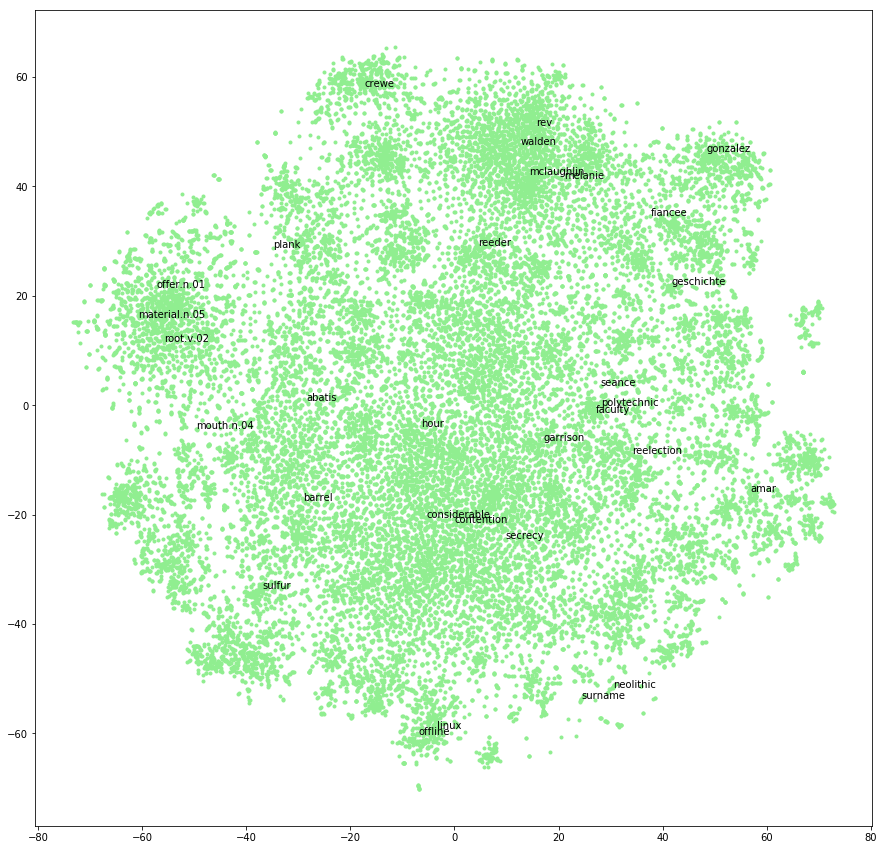

In [19]:
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import random

prob = 0.001

# fit a 2d TSNE model to the vectors
X = model_disambiguation[model_disambiguation.wv.vocab]
pca = PCA(n_components=50)
partial_result = pca.fit_transform(X)
tsne = TSNE(n_components=2)
result = tsne.fit_transform(partial_result)
# create a scatter plot of the projection
plt.figure(figsize=(15, 15))
plt.scatter(result[:, 0], result[:, 1], marker='.', c='lightgreen')
words = list(model_disambiguation.wv.vocab)
for i, word in enumerate(words):
    if random.random() <= prob:
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [59]:
def load_scws_data(scws_path):
    d = dict()
    with open(scws_path, 'r') as f:
        for w in f.readlines():
            data=w.split('\n')[0].split('\t')
            d[int(data[0])] = data[1:]
    return d

In [60]:
scws_path = 'data/SCWS/ratings.txt'

scws_dict = load_scws_data(scws_path)

## Conclusión

El costo de desambiguar palabras es alto debido a la gran cantidad de combinaciones evaluadas por significado, pero se puede reducir en gran medida realizando preprocesado de manera *offline*: tokenización, remoción de *stop words*, *PoS-tagging* y lematización.

Es necesario aplicar técnicas estadísticas sobre el corpus para acotar el espacio de búsqueda de significado para cada término ("mecanismo de atención" no supervisado).

El uso repetido de palabras asociadas a un tópico (ej.: 'title' en un artículo sobre filmografía) usualmente resultaba en desambiguaciones inconsistentes. Es necesario ajustar el proceso de desambiguación para que considere el tópico tratado en cada documento.

Es realmente útil que el modelo preprocesador pueda determinar de manera independiente aquellas palabras a desambiguar, pero en esta iteración no se logró ni fue una gran prioridad. Lo será durante las siguientes iteraciones, donde los casos de prueba tendrán mayor tamaño, y donde es necesaria la independencia de los modelos con respecto al *input* manual de humanos.

Si bien el trabajo desarrollado en esta iteración no alcanzó a cubrir las tareas de validación, como pruebas de coherencia interna y *downstream tasks*, se sostiene que éstas pueden ser razonablemente postergadas en favor de lograr refinaciones en el proceso de desambiguación (tareas que consumen tiempo, pues implican la carga y procesamiento de grandes volúmenes de información).


